In [9]:
# Importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Loading dataset
df = pd.read_csv("data.csv")
df.info()

# Visualizing dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   StartDate              389 non-null    object
 1   EndDate                389 non-null    object
 2   Status                 389 non-null    object
 3   Progress               389 non-null    object
 4   Duration (in seconds)  389 non-null    object
 5   Finished               389 non-null    object
 6   RecordedDate           389 non-null    object
 7   ResponseId             389 non-null    object
 8   DistributionChannel    389 non-null    object
 9   UserLanguage           389 non-null    object
 10  Q1                     387 non-null    object
 11  Q2                     386 non-null    object
 12  Q3                     387 non-null    object
 13  Q4                     386 non-null    object
 14  Q5                     387 non-null    object
 15  Q6                     

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q1,Q2,Q3,Q4,Q5,Q6,Q6_4_TEXT,Q7,Q8,Q9,Q10,Q11,Q11_10_TEXT,Q12,Q12_6_TEXT,Q13,Q13_4_TEXT,Q14,Q15,Q15_4_TEXT,Q16,Q17,Q17_5_TEXT,Q18,Q19,Q20,Q21,Q22
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Gender,Age,Academic Level,Which Medical school are you currently enrolle...,Which geopolitical zone is your school situate...,Ethnicity - Selected Choice,Ethnicity - Others - Text,Have you ever attended a scientific conference...,"If yes, how often do you attend these conferen...",Where do you hear about these conferences from...,Location of Conference (Select all that apply),Reasons for attending conferences (Select all ...,Reasons for attending conferences (Select all ...,What factors do you consider when attending sc...,What factors do you consider when attending sc...,How would you describe your financial situatio...,How would you describe your financial situatio...,How much is your monthly Income (Pocket Money),How do you fund your conference attendance? - ...,How do you fund your conference attendance? - ...,Have you ever faced financial constraints that...,"If yes, please specify the primary financial b...","If yes, please specify the primary financial b...","On average, how much do you expect to pay for ...",Do you think the current registration costs fo...,How do you think the high registration costs f...,What measures do you think could help alleviat...,Is there anything else you would like to share...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID1""}","{""ImportId"":""QID3""}","{""ImportId"":""QID4""}","{""ImportId"":""QID6_TEXT""}","{""ImportId"":""QID25""}","{""ImportId"":""QID7""}","{""ImportId"":""QID7_4_TEXT""}","{""ImportId"":""QID9""}","{""ImportId"":""QID10""}","{""ImportId"":""QID11""}","{""ImportId"":""QID14""}","{""ImportId"":""QID12""}","{""ImportId"":""QID12_10_TEXT""}","{""ImportId"":""QID13""}","{""ImportId"":""QID13_6_TEXT""}","{""ImportId"":""QID15""}","{""ImportId"":""QID15_4_TEXT""}","{""ImportId"":""QID16""}","{""ImportId"":""QID17""}","{""ImportId"":""QID17_4_TEXT""}","{""ImportId"":""QID18""}","{""ImportId"":""QID19""}","{""ImportId"":""QID19_5_TEXT""}","{""ImportId"":""QID20""}","{""ImportId"":""QID21""}","{""ImportId"":""QID22""}","{""ImportId"":""QID23_TEXT""}","{""ImportId"":""QID24_TEXT""}"
2,2024-06-23 17:10:25,2024-06-23 17:19:38,IP Address,100,552,True,2024-06-23 17:19:39,R_8doEvTgpzEjs7m2,anonymous,EN-GB,Male,23-26,600 Level,JUTH,"NC, Nigeria",Others,NaN,Yes,Rarely (Once a year),Flyers,"NW, Nigeria","Networking,Association related activities",NaN,"Relevance to my field of study,Networking oppo...",NaN,Struggling to meet basic needs.,NaN,"Less than ₦20,000",Personal savings,NaN,Yes,"High registration fees,Transportation expenses...",NaN,"Less than ₦10,000",No,Limits access to valuable educational opportun...,1. Scientific conferences registration fees ca...,NaN
3,2024-06-23 23:45:42,2024-06-23 23:52:54,IP Address,100,432,True,2024-06-23 23:52:55,R_8jK3JZrk15DPZh7,anonymous,EN-GB,Male,23-26,600 Level,Abubakar Tafawa Balewa University,"NE, Nigeria",Yoruba,NaN,Yes,Rarely (Once a year),"Conference invitation letters,Flyers,Personal ...","NE, Nigeria",To view current research trends and keep up-to...,NaN,Others (please specify),How it fits within my academic schedule and fi...,Just enough to meet basic needs,NaN,"₦20,000 - ₦40,000",Personal savings,NaN,No,NaN,NaN,"Less than ₦10,000",No,Limits access to valuable educational 

Loaded data consisted of 389 rows and 38 columns with incorrectly named columns, metadata rows and unnecessary columns

In [10]:
# DATA CLEANING 

# Removing first 2 metadata rows
df_clean = pd.read_csv("data.csv", skiprows=[0, 1])

# Resetting index
df_clean.reset_index(drop=True, inplace=True)

# Dropping unnecessary first 10 columns
df_clean = df_clean.iloc[:, 10:]

# Manually renaming columns
df_clean = df_clean.rename(columns={
    '{"ImportId":"QID1"}': 'Gender',
    '{"ImportId":"QID3"}': 'Age',
    '{"ImportId":"QID4"}': 'Academic_level',
    '{"ImportId":"QID6_TEXT"}': 'Medical_school',
    '{"ImportId":"QID25"}': 'Geopolitical_zone',
    '{"ImportId":"QID7"}': 'Ethnicity',
    '{"ImportId":"QID7_4_TEXT"}': 'Ethnicity_others',
    '{"ImportId":"QID9"}': 'Conference_attendance',
    '{"ImportId":"QID10"}': 'Conference_rate',
    '{"ImportId":"QID11"}': 'Conference_information',
    '{"ImportId":"QID14"}': 'Conference_location',
    '{"ImportId":"QID12"}': 'Conference_reasons',
    '{"ImportId":"QID12_10_TEXT"}': 'Conference_reasons_others',
    '{"ImportId":"QID13"}': 'Conference_considerations',
    '{"ImportId":"QID13_6_TEXT"}': 'Conference_considerations_others',
    '{"ImportId":"QID15"}': 'Financial_level',
    '{"ImportId":"QID15_4_TEXT"}': 'Financial_level_others',
    '{"ImportId":"QID16"}': 'Monthly_income',
    '{"ImportId":"QID17"}': 'Conference_funding',
    '{"ImportId":"QID17_4_TEXT"}': 'Conference_funding_others',
    '{"ImportId":"QID18"}': 'Financial_constraints',
    '{"ImportId":"QID19"}': 'Financial_constraints_specific',
    '{"ImportId":"QID19_5_TEXT"}': 'Financial_constraints_specific_others',
    '{"ImportId":"QID20"}': 'Expected_registration_fees',
    '{"ImportId":"QID21"}': 'Affordable_cost',
    '{"ImportId":"QID22"}': 'Effect_of_cost', 
    '{"ImportId":"QID23_TEXT"}': 'Measures', 
    '{"ImportId":"QID24_TEXT"}': 'Suggestions',
})

# Replacing 'others' in the original column with the value from the 'others' column, if present
others_mapping = {
    'Ethnicity': 'Ethnicity_others',
    'Conference_reasons': 'Conference_reasons_others',
    'Conference_considerations': 'Conference_considerations_others',
    'Financial_level': 'Financial_level_others',
    'Conference_funding': 'Conference_funding_others',
    'Financial_constraints_specific': 'Financial_constraints_specific_others',
}

for main_col, other_col in others_mapping.items():
    df_clean[main_col] = df_clean.apply(
        lambda row: row[other_col] if str(row[main_col]).strip().lower() in ['others', 'other', 'others (please specify)', 'other (please specify)'] and pd.notna(row[other_col]) else row[main_col],
        axis=1
    )

# Dropping the 'others' columns
df_clean.drop(columns=others_mapping.values(), inplace=True)

# Visualizing dataset
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Gender                          385 non-null    object
 1   Age                             384 non-null    object
 2   Academic_level                  385 non-null    object
 3   Medical_school                  384 non-null    object
 4   Geopolitical_zone               385 non-null    object
 5   Ethnicity                       385 non-null    object
 6   Conference_attendance           386 non-null    object
 7   Conference_rate                 196 non-null    object
 8   Conference_information          303 non-null    object
 9   Conference_location             255 non-null    object
 10  Conference_reasons              266 non-null    object
 11  Conference_considerations       293 non-null    object
 12  Financial_level                 384 non-null    ob

,Gender,Age,Academic_level,Medical_school,Geopolitical_zone,Ethnicity,Conference_attendance,Conference_rate,Conference_information,Conference_location,Conference_reasons,Conference_considerations,Financial_level,Monthly_income,Conference_funding,Financial_constraints,Financial_constraints_specific,Expected_registration_fees,Affordable_cost,Effect_of_cost,Measures,Suggestions
0,Male,23-26,600 Level,JUTH,"NC, Nigeria",Others,Yes,Rarely (Once a year),Flyers,"NW, Nigeria","Networking,Association related activities","Relevance to my field of study,Networking oppo...",Struggling to meet basic needs.,"Less than ₦20,000",Personal savings,Yes,"High registration fees,Transportation expenses...","Less than ₦10,000",No,Limits access to valuable educational opportun...,1. Scientific conferences registration fees ca...,NaN
1,Male,23-26,600 Level,Abubakar Tafawa Balewa University,"NE, Nigeria",Yoruba,Yes,Rarely (Once a year),"Conference invitation letters,Flyers,Personal ...","NE, Nigeria",To view current research trends and keep up-to...,How it fits within my academic schedule and fi...,Just enough to meet basic needs,"₦20,000 - ₦40,000",Personal savings,No,NaN,"Less than ₦10,000",No,Limits access to valuable educational opportun...,Lower cost of registration fees and encouragem...,I feel; a student fee option should be made av...
2,Male,23-26,600 Level,UNIVERSITY OF JOS,"NC, Nigeria",Egun,Yes,Occasionally (2-3 times a year),"Websites of associations,Flyers,Personal conta...","SE, Nigeria,SS, Nigeria,NC, Nigeria","Learning opportunity,Tourism,Networking,Associ...","Relevance to my field of study,Financial consi...",Just enough to meet basic needs,"Less than ₦20,000",Grants,Yes,"High registration fees,Transportation expenses...","₦21,000 - ₦40,000",No,Limits access to valuable educational opportun...,Considering students for this conferences and ...,NaN
3,Female,20-22,400 Level,University of Benin,"SS, Nigeria",Bini,No,NaN,NaN,NaN,NaN,NaN,Struggling to meet basic needs.,"Less than ₦20,000",NaN,Yes,"High registration fees,Transportation expenses...","Less than ₦10,000",No,Limits access to valuable educational opportun...,Subsidy for students registration,The timeframe might clash with important acade...
4,Male,23-26,600 Level,Ahmadu Bello University Zaria,"NW, Nigeria",Hausa,Yes,Occasionally (2-3 times a year),"Websites of associations,Conference invitation...","SS, Nigeria,SW, Nigeria,NC, Nigeria,NW, Nigeria",To view current research trends and keep up-to...,"Networking opportunities,Professional developm...",Just enough to meet basic needs,"₦20,000 - ₦40,000",Personal savings,Yes,"High registration fees,Transportation expenses...","₦21,000 - ₦40,000",No,Limits access to valuable educational opportun...,Accessible grants and cheaper cost of conferen...,NaN


After initial cleaning, the new dataframe consisted of 387 rows and 22 columns

In [11]:
# Cleaning medical schools
print(df_clean['Medical_school'].unique())

['JUTH' 'Abubakar Tafawa Balewa University ' 'UNIVERSITY OF JOS'
 'University of Benin ' 'Ahmadu Bello University Zaria'
 'Babcock University ' 'Babcock ' 'Babcock university'
 'Ben Carson (Snr.) College of Health and Medical Sciences '
 'Ben Carson Snr. College of Medicine, Babcock university '
 'College of Medicine University of Ibadan'
 'College of Health Sciences University of Ilorin ' 'University of ilorin'
 'YUMSUKMSA ' 'Usmanu Danfodio University Medical Students Association '
 'Ahmadu Bello University ' 'University of Ilorin, Ilorin, Kwara state. '
 'Usman Dan Fodio university Sokoto state' 'UDUS'
 'Usmanu danfodio University sokoto ' 'University of Benin'
 'Usmanu Danfodio University Sokoto '
 'College of Health Sciences, Usmanu Danfodiyo University Sokoto. '
 'Usmanu Dandodiyo University Teaching Hospital '
 'Usmanu Danfodiyo University Sokoto ' 'Usman Danfodio University Sokoto'
 'University of Ilorin ' 'Federal university Dutse jigawa State'
 'Ahmadu Bello University Zaria 

The medical school column is not standardized and has multiple variations pointing to the same school

In [12]:
# Manually mapping out various school variations
df_clean['Medical_school'] = df_clean['Medical_school'].str.strip().str.title()

school_map = {
    'unn': 'University of Nigeria',
    'unec': 'University of Nigeria',
    'enugu campus': 'University of Nigeria',
    'university of nigeria': 'University of Nigeria',
    'unth': 'University of Nigeria',
    'nsukka': 'University of Nigeria',
    
    'ui': 'University of Ibadan',
    'uith': 'University of Ibadan',
    'ibadan': 'University of Ibadan',
    'university of ibadan': 'University of Ibadan',
    'college of medicine university of ibadan': 'University of Ibadan',
    
    'abu': 'Ahmadu Bello University',
    'abuth': 'Ahmadu Bello University',
    'ahmadu bello university medical school': 'Ahmadu Bello University',
    'zaria': 'Ahmadu Bello University',
    'ahmadu': 'Ahmadu Bello University',

    'obafemi awolowo university, ile-ife.': 'Obafemi Awolowo University',
    'obafemi': 'Obafemi Awolowo University',
    'oau': 'Obafemi Awolowo University',

    'nnamdi azikiwe university, awka': 'Nnamdi Azikiwe University',
    'unizik': 'Nnamdi Azikiwe University',
    'nnamdi': 'Nnamdi Azikiwe University',
    'nauth': 'Nnamdi Azikiwe University',
    'naumsa': 'Nnamdi Azikiwe University',
    
    'juth': 'University of Jos',
    'university of jos plateau state': 'University of Jos',
    'jos': 'University of Jos',

    'al-hikmah': 'Al-Hikmah University Ilorin',
    
    'unilorin': 'University of Ilorin',
    'ilorin': 'University of Ilorin',
    'college of health sciences university of ilorin': 'University of Ilorin',

    'uniben': 'University of Benin',
    'benin': 'University of Benin',

    'uniport': 'University of Portharcourt',
    'port harcourt': 'University of Portharcourt',

    'futo': 'Federal University of Technology Owerri',
    'federal university of technology, owerri.': 'Federal University of Technology Owerri',
    'owerri': 'Federal University of Technology Owerri',

    'udus': 'Usmanu Danfodiyo University',
    'uduth': 'Usmanu Danfodiyo University',
    'usmanu': 'Usmanu Danfodiyo University',
    'usman': 'Usmanu Danfodiyo University',
    'usmanu danfodio university medical students association': 'Usmanu Danfodiyo University',

    'ebonyi': 'Ebonyi State University',
    'ebsu': 'Ebonyi State University',
    'ebsuth': 'Ebonyi State University',

    'yumsukmsa': 'Yusuf Maitama Sule University',

    'gombe state university college of medical science': 'Gombe State University',
    'gombe': 'Gombe State University',

    'ysu': 'Yobe State University',
    'yobe': 'Yobe State University',

    'university of abuja, college of health sciences': 'University of Abuja',
    'abuja': 'University of Abuja',
    'uniabuja': 'University of Abuja',

    'dutse': 'Federal University Dutse',

    'esuth': 'Enugu State University',
    'esumsa': 'Enugu State University',
    'esucom': 'Enugu State University',
    'enugu state': 'Enugu State University',
    
    'uniosun': 'Osun State University',
    'osun': 'Osun State University',
    'osumsa': 'Osun State University',

    'buk': 'Bayero University',
    'bayero': 'Bayero University',

    'bsu': 'Benue State University',
    'benue': 'Benue State University',
    
    'coou': 'Chukwuemeka Odumegwu Ojukwu University',
    'cooumsa': 'Chukwuemeka Odumegwu Ojukwu University',
    'chukwuemeka': 'Chukwuemeka Odumegwu Ojukwu University',

    'delta state university,abraka': 'Delta State University',
    'delsu': 'Delta State University',
    'abraka': 'Delta State University',
    
    'river state university': 'Rivers State University',
    'rivers': 'Rivers State University',
    
    'abubakar tafawa balewa university, bauchi.': 'Abubakar Tafawa Balewa University',
    'abubakar': 'Abubakar Tafawa Balewa University',

    'kasu': 'Kaduna State University',

    'kwara state university medical school': 'Kwara State University',
    'Kwara': 'Kwara State University',
    'malete': 'Kwara State University',

    'ekounimed': 'Eko University of Medical and Health Sciences',

    'olabisi onabanjo university teaching hospital': 'Olabisi Onabanjo University',
    'oou': 'Olabisi Onabanjo University',
    'ooumsa': 'Olabisi Onabanjo University',
    'oouth': 'Olabisi Onabanjo University',

    'federal university of health sciences otukpo benue state': 'Federal University of Health Sciences Otukpo',
    'otukpo': 'Federal University of Health Sciences Otukpo',
    
    'gregory university uturu, abia state': 'Gregory University Uturu',
    'gregory': 'Gregory University Uturu',

    'abia state': 'Abia State University',
    
    'umahi': 'David Umahi Federal University',

    'sumas': 'State University of Medical and Applied Sciences',
    'state university of medical and applied science': 'State University of Medical and Applied Sciences',
    'sumsa': 'State University of Medical and Applied Sciences',
    'state university of medical and applied science igbo-eno enugu state nigeria': 'State University of Medical and Applied Sciences',

    'federal university of health sciences azare': 'Federal University of Health Sciences Azare',
    'azare': 'Federal University of Health Sciences Azare',

    'federal university lokoja, kogi state': 'Federal University Lokoja',
    'lokoja': 'Federal University Lokoja',

    'godfrey': 'Godfrey Okoye University',
    
    'bu': 'Babcock University',
    'babcock': 'Babcock University',
    'ben carson snr. college of medicine': 'Babcock University',
    'ben carson (snr.) college of health and medical sciences': 'Babcock University',
    'benjamin carson': 'Babcock University', 

    'maiduguri': 'University Of Maiduguri',
    'umth': 'University Of Maiduguri',
    
    'afe': 'Afe Babalola University',
    'abuad': 'Afe Babalola University',
    'afebabalola university': 'Afe Babalola University',

    'lagos state college of medicine': 'Lagos State University',
    'lasu': 'Lagos State University',
    
    'university of lagos': 'University of Lagos',
    'unilag': 'University of Lagos',

    'cu': 'Covenant University',
    
    'nile university of nigeria': 'Nile University',
    
    'madonna': 'Madonna University',

    'alex ekwueme federal teaching hospital': 'Alex Ekwueme Federal University',
    'alex ekwueme': 'Alex Ekwueme Federal University',
    'alex-ekwueme federal university ndufu alike ikwo': 'Alex Ekwueme Federal University',
    'ae fumsa': 'Alex Ekwueme Federal University',
    'aefunai': 'Alex Ekwueme Federal University',
    'ae-funai': 'Alex Ekwueme Federal University',
    'ae funai': 'Alex Ekwueme Federal University',
    'ndufu': 'Alex Ekwueme Federal University',

    'bowen': 'Bowen University',
    
    'ladoke akintola university of technology, ogbomosho oyo state, nigeria.': 'Ladoke Akintola University of Technology',
    'ladoke': 'Ladoke Akintola University of Technology',
    'lautech': 'Ladoke Akintola University of Technology',

    'baze university abuja': 'Baze University',
    
    'federal university of health sciences ila- orangun': 'Federal University of Health Sciences Ila-Orangun',
    'federal university of health sciences ila orangun': 'Federal University of Health Sciences Ila-Orangun',
    'fuhsi': 'Federal University of Health Sciences Ila-Orangun',
    'ila-orangun': 'Federal University of Health Sciences Ila-Orangun',
}

# Removing capitalized prepositions
def smart_title(text):
    # Define words to skip unless they are the first word
    skip_words = {"a", "an", "the", "and", "for", "of", "on"}

    words = text.lower().split()
    titled = [words[0].capitalize()]  # Always capitalize the first word

    for word in words[1:]:
        if word in skip_words:
            titled.append(word)
        else:
            titled.append(word.capitalize())
    
    return " ".join(titled)

# Standardization function
def standardize_school(name):
    name = str(name).lower()
    for keyword, standard_name in school_map.items():
        if keyword in name:
            return standard_name
    return smart_title(name)  # return original if no match

# Visualising the standardized medical schools column
df_clean["Standardized_school"] = df_clean["Medical_school"].apply(standardize_school)
print(df_clean['Standardized_school'].unique())

['University of Jos' 'Ahmadu Bello University' 'University of Benin'
 'Babcock University' 'University of Ibadan' 'University of Ilorin'
 'Yusuf Maitama Sule University' 'Usmanu Danfodiyo University'
 'Federal University Dutse' 'Ladoke Akintola University of Technology'
 'University of Nigeria' 'Afe Babalola University' 'Osun State University'
 'Obafemi Awolowo University' 'Gregory University Uturu'
 'Gombe State University' 'Nan' 'Bayero University'
 'Chukwuemeka Odumegwu Ojukwu University' 'University Of Maiduguri'
 'Benue State University' 'Federal University Lokoja'
 'Delta State University' 'Kaduna State University'
 'University of Portharcourt' 'Kwara State University' 'Novena University'
 'Federal University of Health Sciences Azare' 'Ebonyi State University'
 'Nnamdi Azikiwe University'
 'Eko University of Medical and Health Sciences'
 'Olabisi Onabanjo University' 'Yobe State University'
 'Lagos State University' 'University of Calabar'
 'Alex Ekwueme Federal University' 'Enug

Responses were gotten from 49 medical schools across the country, with three respondents not including their medical school, and one response from a nursing student(specific school not included)

In [13]:
# Dropping grossly unfilled data
df_analyze = df_clean.dropna(thresh=df_clean.shape[1] - 11) #dropping rows with less than half of the questions answered
df_analyze.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 386
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Gender                          382 non-null    object
 1   Age                             381 non-null    object
 2   Academic_level                  382 non-null    object
 3   Medical_school                  382 non-null    object
 4   Geopolitical_zone               382 non-null    object
 5   Ethnicity                       382 non-null    object
 6   Conference_attendance           383 non-null    object
 7   Conference_rate                 195 non-null    object
 8   Conference_information          303 non-null    object
 9   Conference_location             255 non-null    object
 10  Conference_reasons              266 non-null    object
 11  Conference_considerations       293 non-null    object
 12  Financial_level                 381 non-null    ob

After final cleaning, the dataset to be used for analysis consists of 383 rows and 23 columns

In [14]:
# ANALYSIS

# Respondent distribution
print('Age Distribution:')
print(df_analyze['Age'].value_counts(), '\n')

print('Academic level Distribution:')
print(df_analyze['Academic_level'].value_counts(), '\n')

print('Gender Distribution:')
print(df_analyze['Gender'].value_counts(), '\n')

print('Medical school Distribution:')
print(df_analyze['Standardized_school'].value_counts(), '\n')

print('Geopolitical Zones:')
print(df_analyze['Geopolitical_zone'].value_counts(), '\n')

Age Distribution:
23-26    140
20-22    138
<20       78
27-30     20
>30        5
Name: Age, dtype: int64 

Academic level Distribution:
400 Level    92
600 Level    83
300 Level    72
500 Level    52
200 Level    49
100 Level    34
Name: Academic_level, dtype: int64 

Gender Distribution:
Male      196
Female    186
Name: Gender, dtype: int64 

Medical school Distribution:
University of Nigeria                                38
University of Ibadan                                 23
Ahmadu Bello University                              22
University of Ilorin                                 21
University of Benin                                  18
University of Portharcourt                           18
Usmanu Danfodiyo University                          15
Olabisi Onabanjo University                          15
University Of Maiduguri                              14
Afe Babalola University                              13
Nnamdi Azikiwe University                            13
Alex E

Responses were gotten from all geo-political zones in the country and across all academic levels in 49 medical schools. 
The respondents comprised mostly of 4th year medical students aged 23 to 26 and we had more males than females.

Summary Table: Conference Attendance (in %)
No     57.7
Yes    42.3
Name: Conference_attendance, dtype: float64


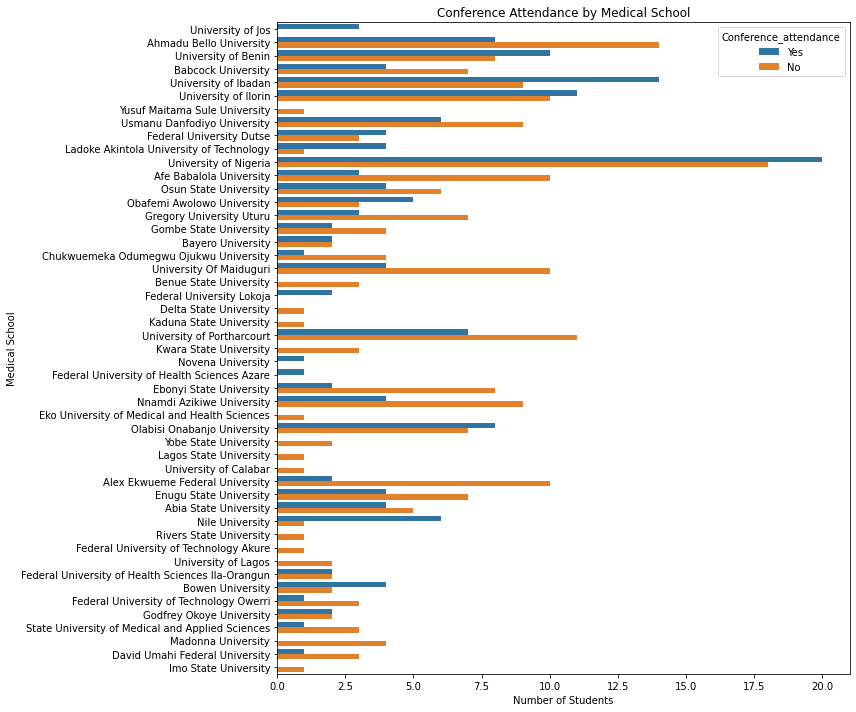

In [15]:
# Analyzing conference attendance rate
print("Summary Table: Conference Attendance (in %)")
attendance_percent = df_analyze['Conference_attendance'].value_counts(normalize=True) * 100
print(attendance_percent.round(2))

# Attendance by medical school
plt.figure(figsize=(12,10))
sns.countplot(data=df_analyze[
    (df_analyze['Conference_attendance'].notna()) & 
    (df_analyze['Standardized_school'] != 'Nan') & 
    (df_analyze['Standardized_school'] != 'Nursing') # Drop 'Nursing' from 'Standardized_school'
],
y='Standardized_school',
hue='Conference_attendance',
)
plt.title("Conference Attendance by Medical School")
plt.xlabel("Number of Students")
plt.ylabel("Medical School")
plt.tight_layout()
plt.show()

**42.3%** of students reported ever attending a conference before 

Summary Table: Conference Attendance by Gender (in %)
Conference_attendance   No  Yes  Total  Attendance_Rate (%)
Gender                                                     
Male                   102   94    196                47.96
Female                 119   67    186                36.02
Chi-square: 5.098842877008707 p-value: 0.023941809764598188


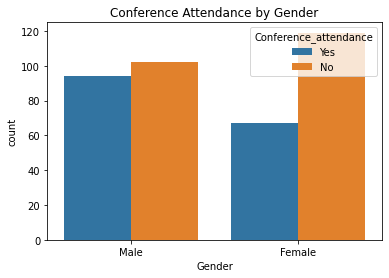

        Total Non-Attendees  Cited Financial Constraint  Percentage (%)
Female                  186                          89            47.8
Male                    196                         118            60.2


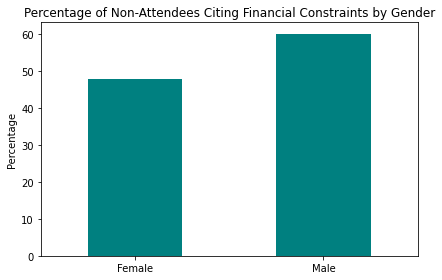

In [16]:
# Attendance by gender
print("Summary Table: Conference Attendance by Gender (in %)")
attendance_by_gender = df_analyze.groupby(['Gender', 'Conference_attendance']).size().unstack().fillna(0)
attendance_by_gender['Total'] = attendance_by_gender.sum(axis=1)
attendance_by_gender['Attendance_Rate (%)'] = ((attendance_by_gender['Yes'] / attendance_by_gender['Total']) * 100).round(2)
print(attendance_by_gender.sort_values(by='Attendance_Rate (%)', ascending=False))

contingency_gender = pd.crosstab(df_analyze['Gender'], df_analyze['Conference_attendance'])
chi2, p, dof, expected = chi2_contingency(contingency_gender)
print(f"Chi-square: {chi2}", f"p-value: {p}")

sns.countplot(data=df_analyze, x='Gender', hue='Conference_attendance')
plt.title("Conference Attendance by Gender")
plt.show()

# Financial constraint by gender

# Filtering for only respondents who don't attend conferences
non_attendees = df_analyze.copy()
non_attendees['financial_constraint'] = non_attendees['Conference_considerations'].astype(str).str.lower().str.contains("financ")
# Grouping by gender 
gender_constraint_counts = non_attendees.groupby('Gender')['financial_constraint'].sum()
# Proportions
gender_counts = non_attendees['Gender'].value_counts()
gender_proportions = (gender_constraint_counts / gender_counts) * 100
summary = pd.DataFrame({
    'Total Non-Attendees': gender_counts,
    'Cited Financial Constraint': gender_constraint_counts,
    'Percentage (%)': gender_proportions.round(1)
})
print(summary)

# Bar plot of the percentages
summary['Percentage (%)'].plot(kind='bar', color='teal')
plt.title("Percentage of Non-Attendees Citing Financial Constraints by Gender")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Out of 196 male students, 94 (47.96%) reported attending conferences, while 102 (52.04%) did not. For female students, 67 out of 186 (36.02%) attended, and 119 (63.98%) did not. **A Chi-square test was performed and revealed a statistically significant association between gender and conference attendance, χ2(1)=5.10, p=0.024**

On grouping with financial considerations, males were found to be more likely to cite financial constraints. 

Summary Table: Conference Attendance by Monthly Income level (in %)
Conference_attendance  No  Yes  Total  Attendance_Rate (%)
Monthly_income                                            
Less than ₦20,000      72   49    121                40.50
₦20,000 - ₦40,000      83   50    133                37.59
₦41,000 - ₦60,000      30   24     54                44.44
₦61,000 - ₦80,000      14   12     26                46.15
₦81,000 - ₦100,000     11   11     22                50.00
More than ₦100,000     10   15     25                60.00
Chi-square: 5.372740398516863 p-value: 0.37210218726220184


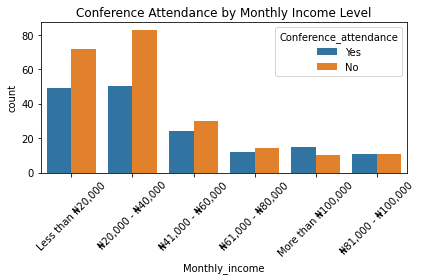

                    Total Non-Attendees  Cited Financial Constraint  Percentage (%)
Less than ₦20,000                   121                          77            63.6
₦20,000 - ₦40,000                   133                          65            48.9
₦41,000 - ₦60,000                    54                          31            57.4
₦61,000 - ₦80,000                    26                          11            42.3
₦81,000 - ₦100,000                   22                          10            45.5
More than ₦100,000                   25                          14            56.0


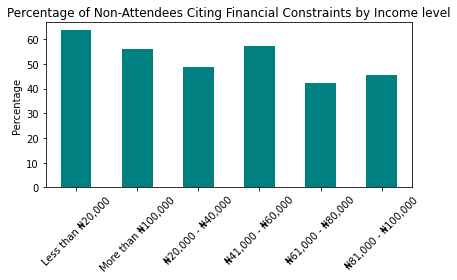

In [17]:
# Attendance by income level
print("Summary Table: Conference Attendance by Monthly Income level (in %)")
income_order = ["Less than ₦20,000", "₦20,000 - ₦40,000", "₦41,000 - ₦60,000", "₦61,000 - ₦80,000", "₦81,000 - ₦100,000", "More than ₦100,000"]
attendance_by_income = df_analyze.groupby(['Monthly_income', 'Conference_attendance']).size().unstack().fillna(0)
attendance_by_income['Total'] = attendance_by_income.sum(axis=1)
attendance_by_income['Attendance_Rate (%)'] = ((attendance_by_income['Yes'] / attendance_by_income['Total']) * 100).round(2)
print(attendance_by_income.sort_values(by='Attendance_Rate (%)', ascending=False).reindex(income_order))

contingency_income = pd.crosstab(df_analyze['Monthly_income'], df_analyze['Conference_attendance'])
chi2, p, dof, expected = chi2_contingency(contingency_income)
print(f"Chi-square: {chi2}", f"p-value: {p}")

sns.countplot(data=df_analyze, x='Monthly_income', hue='Conference_attendance')
plt.title("Conference Attendance by Monthly Income Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filtering for only respondents who don't attend conferences
# Grouping by income level
income_constraint_counts = non_attendees.groupby('Monthly_income')['financial_constraint'].sum()
income_order = ["Less than ₦20,000", "₦20,000 - ₦40,000", "₦41,000 - ₦60,000", "₦61,000 - ₦80,000", "₦81,000 - ₦100,000", "More than ₦100,000"]

# Proportions
income_counts = non_attendees['Monthly_income'].value_counts()
income_proportions = (income_constraint_counts / income_counts) * 100

summary = pd.DataFrame({
    'Total Non-Attendees': income_counts,
    'Cited Financial Constraint': income_constraint_counts,
    'Percentage (%)': income_proportions.round(1)
})

print(summary.reindex(income_order))

# Barplot of the percentages
summary['Percentage (%)'].plot(kind='bar', color='teal')
plt.title("Percentage of Non-Attendees Citing Financial Constraints by Income level")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There was a general increase in percentage of respondents who attend conferences as their income level (measured with monthly income) went from less than ₦20,000 to more than ₦100,000. A Chi-square test was performed and revealed that **there was not a statistically significant association between income level (monthly income) and conference attendance, χ2(5)=5.37, p=0.372**
Cross-analysis with financial considerations showed that **students with less income were more likely to cite financial constraints as a hinderance to conference attendance.**

Summary Table: Conference Attendance by Geopolitical Zones (in %)
Conference_attendance  No  Yes  Total  Attendance_Rate (%)
Geopolitical_zone                                         
NC, Nigeria            20   28     48                58.33
SW, Nigeria            58   49    107                45.79
NW, Nigeria            19   16     35                45.71
SS, Nigeria            24   18     42                42.86
NE, Nigeria            18    9     27                33.33
SE, Nigeria            82   41    123                33.33
Chi-square: 10.71146721808781 p-value: 0.05741055061405429


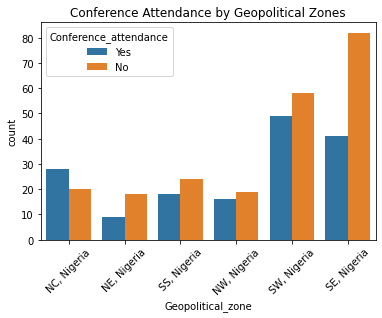

  Geopolitical_zone  Conferences_Held
0                SW               113
1                SE                80
2                NC                65
3                SS                37
4                NW                27
5                NE                25


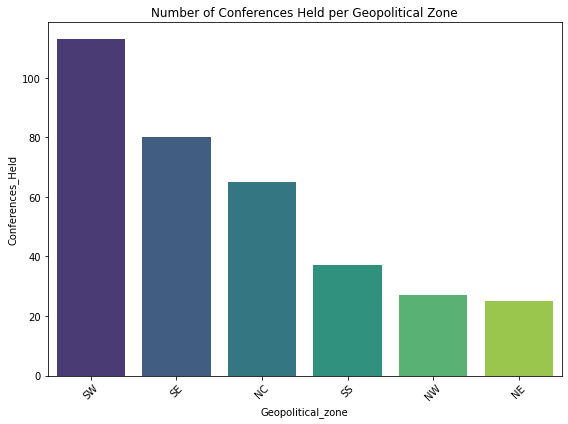

,Attended in Other Zones,Attended in Own Zone
Geopolitical_zone,,
"NC, Nigeria",4,24
"NE, Nigeria",2,7
"NW, Nigeria",6,10
"SE, Nigeria",4,37
"SS, Nigeria",3,15
"SW, Nigeria",2,47


Chi-square: 48.91600308377538 p-value: 0.008522506141457373


In [18]:
# Attendance by geopolitical zone
print("Summary Table: Conference Attendance by Geopolitical Zones (in %)")
attendance_by_zone = df_analyze.groupby(['Geopolitical_zone', 'Conference_attendance']).size().unstack().fillna(0)
attendance_by_zone['Total'] = attendance_by_zone.sum(axis=1)
attendance_by_zone['Attendance_Rate (%)'] = ((attendance_by_zone['Yes'] / attendance_by_zone['Total']) * 100).round(2)
print(attendance_by_zone.sort_values(by='Attendance_Rate (%)', ascending=False))

contingency_income = pd.crosstab(df_analyze['Geopolitical_zone'], df_analyze['Conference_attendance'])
chi2, p, dof, expected = chi2_contingency(contingency_income)
print(f"Chi-square: {chi2}", f"p-value: {p}")

sns.countplot(data=df_analyze, x='Geopolitical_zone', hue='Conference_attendance')
plt.title("Conference Attendance by Geopolitical Zones")
plt.xticks(rotation=45)
plt.show()

# Checking if zonal attendance correleates with proximity to conferences
# Conferences per zone
df_exploded = df_analyze.assign(
    Conference_zone=df_analyze['Conference_location'].astype(str).str.split(',\s*')
).explode('Conference_zone')

# Dropping unwanted values
df_exploded = df_exploded[
    ~df_exploded['Conference_zone'].isin(['Nigeria', 'nan'])  # Drop specific values
]
conferences_by_zone = (
    df_exploded['Conference_zone']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Geopolitical_zone', 'Conference_zone': 'Conferences_Held'})
)
print(conferences_by_zone)

# Barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=conferences_by_zone, x='Geopolitical_zone', y='Conferences_Held', palette='viridis')
plt.title("Number of Conferences Held per Geopolitical Zone")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Filtering only those who attend
attended_df = df_analyze[df_analyze["Conference_attendance"].str.lower().str.strip() == "yes"].copy()

# Cleaning the zones
attended_df["respondent_zone_clean"] = attended_df["Geopolitical_zone"].astype(str).str.strip().str.lower()
attended_df["conference_zones_list"] = attended_df["Conference_location"].astype(str)\
    .str.lower().str.strip().str.split(",")

attended_df['Attended_in_own_zone'] = attended_df.apply(
    lambda row: str(row['Geopolitical_zone']).strip().lower() in str(row['Conference_location']).strip().lower(),
    axis=1
)

# Grouping and creating table
attendance_by_zone = attended_df.groupby(["Geopolitical_zone", "Attended_in_own_zone"]).size().unstack(fill_value=0)

attendance_by_zone.columns = ['Attended in Other Zones', 'Attended in Own Zone']
attendance_by_zone = attendance_by_zone.rename(columns={
    True: "Attended in own zone",
    False: "Attended in other zone"
})

# Displaying table
display(attendance_by_zone)
contingency_table = pd.crosstab(df_analyze['Conference_attendance'], df_analyze['Conference_location'])
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square: {chi2}", f"p-value: {p}")

* A Chi-square test of independence was conducted to examine the association between geopolitical zone and conference attendance. The results indicated **no statistically significant association between geopolitical zone and conference attendance, χ2(5)=10.71, p=0.057**
* Students attended conferences more in the Southern region of the country (The south west being the highest) and less in the North with the North East. This variation could be due to several factors like population, security, etc. 
* On examining the association between geopolitical zone and whether students attended conferences in their own zone versus other zones, a chi-square test was performed and the results indicated a statistically significant association, χ2(5)=48.92, p=0.009, showing **attendance to conferences is significantly related to a student's preference for attending conferences within their own zone or in other zones. This could be due to accomodation and travel considerations.**

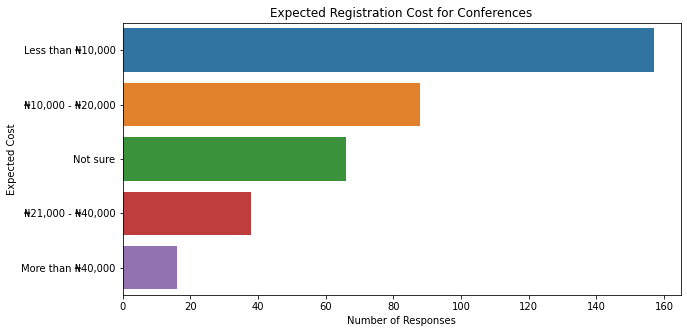

Monthly_income              Less than ₦20,000  ₦20,000 - ₦40,000  ₦41,000 - ₦60,000  ₦61,000 - ₦80,000  ₦81,000 - ₦100,000  More than ₦100,000
Expected_registration_fees                                                                                                                    
Less than ₦10,000                    0.482143           0.387097           0.400000           0.500000            0.400000            0.400000
₦10,000 - ₦20,000                    0.250000           0.416667           0.500000           0.444444            0.428571            0.666667
Not sure                             0.304348           0.407407           0.500000           0.500000            0.500000            1.000000
₦21,000 - ₦40,000                    0.538462           0.222222           0.428571           0.666667            0.750000            0.500000
More than ₦40,000                    0.600000           0.500000           0.500000                NaN            1.000000            1.000000

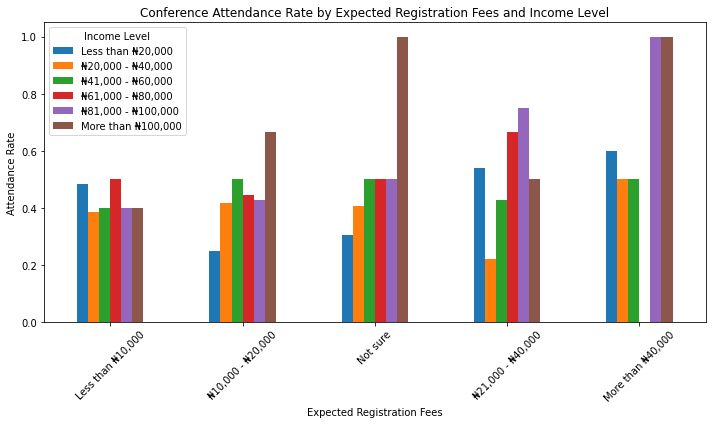

In [25]:
# Expected registration cost
plt.figure(figsize=(10, 5))
sns.countplot(data=df_analyze, y='Expected_registration_fees', order=df_analyze['Expected_registration_fees'].value_counts().index)
plt.title("Expected Registration Cost for Conferences")
plt.xlabel("Number of Responses")
plt.ylabel("Expected Cost")
plt.show()

df_grouped = df_analyze.dropna(subset=['Expected_registration_fees', 'Conference_attendance', 'Monthly_income']).copy()
df_grouped['Attendance_binary'] = df_grouped['Conference_attendance'].map({'Yes': 1, 'No': 0})
fees_order = ["Less than ₦10,000", "₦10,000 - ₦20,000", "Not sure", "₦21,000 - ₦40,000", "More than ₦40,000"]
income_order = ["Less than ₦20,000", "₦20,000 - ₦40,000", "₦41,000 - ₦60,000", "₦61,000 - ₦80,000", "₦81,000 - ₦100,000", "More than ₦100,000"]

# Encoding attendance
pivot_table = df_grouped.groupby(['Expected_registration_fees', 'Monthly_income'])['Attendance_binary'].mean().unstack()
print(pivot_table.reindex(columns=income_order, index=fees_order))

pivot_table.reindex(columns=income_order, index=fees_order).plot(kind='bar', figsize=(10, 6))
plt.title('Conference Attendance Rate by Expected Registration Fees and Income Level')
plt.ylabel('Attendance Rate')
plt.xlabel('Expected Registration Fees')
plt.xticks(rotation=45)
plt.legend(title='Income Level')
plt.tight_layout()
plt.show()

* The countplot shows that expected conference registration fees decreased going from less than ₦10,000 showing that students expect to pay less fees to attend conferences.

* The table illustrates the proportion of respondents, within each monthly income bracket, who selected various categories for expected conference registration fees. For instance, among those earning 'Less than ₦20,000', approximately 48.21% expected registration fees 'Less than ₦10,000', while 25.00% expected '₦10,000 - ₦20,000'.
Notably, for the 'More than ₦100,000' income group, 66.67% expected fees '₦10,000 - ₦20,000', and 100% of those unsure about fees or expecting 'More than ₦40,000' belonged to this highest income category. Conversely, respondents in the lower income brackets, such as 'Less than ₦20,000', showed a higher proportion expecting 'Less than ₦10,000' fees. There appears to be varied expectations across income groups, with a tendency for higher income groups to anticipate higher registration fees.

* Attendance rates are not uniform across either expected fees or income levels, **indicating a complex relationship**. the chart strongly indicates that **an individual's monthly income level plays a significant role in their conference attendance, particularly in conjunction with their expectations about registration fees.** Higher income levels appear to mitigate the deterrent effect of higher or uncertain fees.


Percentage Distribution within Income Levels (%):
Conference_rate     Occasionally (2-3 times a year)  Rarely (Once a year)  Regularly (4 to 5 times a year)
Monthly_income                                                                                            
Less than ₦20,000                         20.338983             76.271186                         3.389831
₦20,000 - ₦40,000                         23.437500             75.000000                         1.562500
₦41,000 - ₦60,000                         19.230769             80.769231                         0.000000
₦61,000 - ₦80,000                         14.285714             85.714286                         0.000000
₦81,000 - ₦100,000                         8.333333             91.666667                         0.000000
More than ₦100,000                        31.578947             57.894737                        10.526316


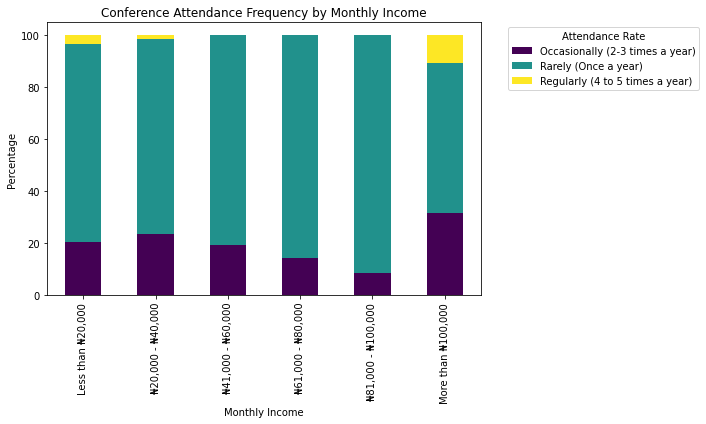

In [26]:
# Creating a crosstab to compare attendance rate with monthly income
income_order = ["Less than ₦20,000", "₦20,000 - ₦40,000", "₦41,000 - ₦60,000", "₦61,000 - ₦80,000", "₦81,000 - ₦100,000", "More than ₦100,000"]
attendance_vs_income = pd.crosstab(df_analyze['Monthly_income'], df_analyze['Conference_rate'])

# Normalizing by row to show percentage distribution within each income level
attendance_vs_income_percent = attendance_vs_income.div(attendance_vs_income.sum(axis=1), axis=0) * 100
print("\nPercentage Distribution within Income Levels (%):")
print(attendance_vs_income_percent.reindex(index=income_order))

# Stacked bar chart for visual comparison
attendance_vs_income_percent.reindex(index=income_order).plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')
plt.title('Conference Attendance Frequency by Monthly Income')
plt.ylabel('Percentage')
plt.xlabel('Monthly Income')
plt.legend(title='Attendance Rate', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The table reveals that while infrequent conference attendance is prevalent across the board, higher monthly income levels, particularly above ₦100,000, correlate with a distinct increase in the frequency of conference attendance. Conversely, middle-income groups appear to be largely restricted to rare or occasional participation

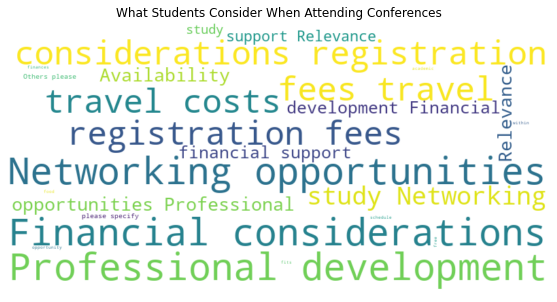

In [21]:
# Considerations for attending conferences
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["field", "etc", "na", "none", "None", "Nil", "Nothing",])

text = " ".join(df_analyze["Conference_considerations"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("What Students Consider When Attending Conferences")
plt.show()

The word cloud provides compelling evidence that for students, **financial implications (registration fees, travel costs, and overall financial considerations) are the most significant factors influencing their decision to attend conferences.** Closely following, and serving as key motivators, are the prospects of **professional development** and **networking opportunities**. The relevance of the conference content is also considered, but to a lesser extent than the financial and career-related benefits. This analysis suggests that strategies to increase student attendance should heavily focus on reducing financial burdens and clearly articulating the professional and networking value of the conference.

                                                     Barrier  Count
                     Transportation expenses (transportation    221
                                              accommodation)    221
                                      High registration fees    218
Lack of funding/support from institution or external sources    170
                                      Accommodation expenses    168
                                      Other (please specify)     11
                                    I'm scared of travelling      1


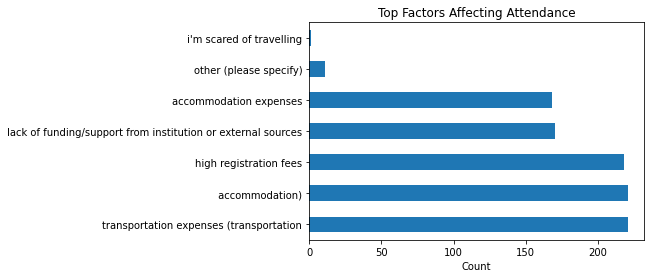

In [22]:
# Financial factors affecting attendance

# Splitting comma-separated answers into list
barrier_series = df_analyze['Financial_constraints_specific'].dropna().str.split(',')
all_barriers = [item.strip() for sublist in barrier_series for item in sublist]
barrier_counts = Counter(all_barriers)

# Displaying top barriers
barrier_df = pd.DataFrame(barrier_counts.items(), columns=["Barrier", "Count"]).sort_values(by="Count", ascending=False)
barrier_df = barrier_df.to_string(index=False)
print(barrier_df)

# Flatten all responses and count
factors = df_analyze['Financial_constraints_specific'].dropna().str.lower().str.split(',')
flattened = [item for sublist in factors for item in sublist]
factor_counts = pd.Series(flattened).value_counts()

factor_counts.plot(kind='barh', title='Top Factors Affecting Attendance')
plt.xlabel("Count")
plt.show()

The top four most frequently cited factors are all directly related to the financial burden of attending conferences, accounting for the vast majority of concerns.
- **"Transportation expenses (transportation and accommodation)"** and **"High registration fees"** are the most significant barriers, both cited by 221 and 218 respondents respectively. This highlights that the cost of getting to and staying at a conference is as much of a deterrent as the cost of the event itself.
- **"Lack of funding/support from institution or external sources"** ranks highly with 170 mentions. This indicates that even when students are keen to attend, the absence of financial aid or institutional backing poses a substantial obstacle.
- **"Others"** received only 11 mentions, suggesting that the listed categories cover most common issues.
- **"I'm scared of travelling"** was an almost negligible factor, cited by only 1 respondent. This indicates that psychological or personal travel fears are not a widespread barrier for the student population surveyed.

In [23]:
# logistic regression

# Ensuring no missing values in relevant columns
df_log = df_analyze[['Conference_attendance', 'Expected_registration_fees', 'Monthly_income']].dropna()

# Converting target variable to binary
df_log['Conference_attendance_binary'] = df_log['Conference_attendance'].map({'Yes': 1, 'No': 0})

# One-hot encoding categorical predictors
X = pd.get_dummies(df_log[['Expected_registration_fees', 'Monthly_income']], drop_first=True)

# Target variable
y = df_log['Conference_attendance_binary']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Organizing and displaying the coefficients with their labels
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient (Log-Odds)': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
}).sort_values(by='Odds Ratio', ascending=False)

print("Intercept (Log-Odds):", model.intercept_[0])
print("\nLogistic Regression Results:")
print(coef_df)

# Predicting on test data
y_pred = model.predict(X_test)

# Checking accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Intercept (Log-Odds): -0.06371741708025955

Logistic Regression Results:
                                       Variable  Coefficient (Log-Odds)  Odds Ratio
4             Monthly_income_More than ₦100,000                0.649618    1.914808
0  Expected_registration_fees_More than ₦40,000                0.602479    1.826642
3  Expected_registration_fees_₦21,000 - ₦40,000                0.439140    1.551372
7              Monthly_income_₦61,000 - ₦80,000                0.347267    1.415195
8             Monthly_income_₦81,000 - ₦100,000                0.266778    1.305751
6              Monthly_income_₦41,000 - ₦60,000               -0.021601    0.978630
5              Monthly_income_₦20,000 - ₦40,000               -0.211169    0.809637
2  Expected_registration_fees_₦10,000 - ₦20,000               -0.292141    0.746664
1           Expected_registration_fees_Not sure               -0.452134    0.636269
Model Accuracy: 0.55


The model demonstrated the following:
- **Students with higher monthly incomes** were significantly more likely to attend conferences. Notably, those earning **above ₦100,000 per month** had nearly **double the odds** of attending (odds ratio = **1.91**) compared to those earning less than ₦20,000.
- Similarly, students who **expected registration fees to be above ₦40,000** also had high odds of attending (odds ratio = **1.83**). This suggests that students with higher financial capacity are both aware of and more prepared for such costs.
- Interestingly, **students who were unsure of the expected registration fee** had **significantly lower odds of attendance** (odds ratio = **0.64**), indicating that uncertainty about costs may be a barrier to participation.
- Mid-income groups (₦20,000–₦40,000) had **slightly reduced odds** of attending compared to both lower and higher income groups, possibly reflecting a financial squeeze that limits discretionary spending.
- Intercept (Log-Odds): **-0.064**
Interpretation: The baseline group has a ~48% chance of attending, decreasing with lower income and vague fee expectations.

1. yes, it happened to me, i was about to go to a conference, but because of the financial barriers i couldn't make it.

2. it could be very long and sometimes boring

3. lack and late nformation dissemination to students

4. it should be held more frequently around the country to ease the access

5. yes, this restricts the rate of scientific advancement that could be beneficial to medicine

6. information communication and technology, transport and accomodation fees e.t.c.

7. most of our institutions are not research oriented, this students find these conferences less appealing and of no interest to them.

8. there should also be ways medical students to earn well enough to reduce financial burdend

9. not one i can remember now

10. yes, here are some additional points:  1. limited funding for research: medical students in nigeria often lack funding to conduct research, making it difficult to present papers at conferences.  2. high travel costs: traveling from nigeria to internation

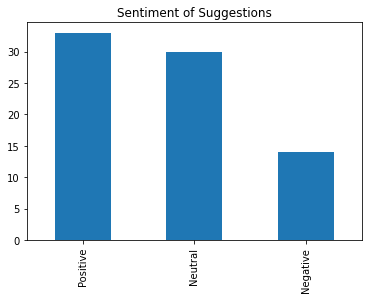

In [24]:
# RECOMMENDATIONS

# Irrelevant/noise phrases to filter out
irrelevant_responses = ["no", "none", "nothing else", "not really", "none for now", "oh, no", "nil", "nothing", "none at all", "can't think of any"]

# Normalizing
df_analyze = df_analyze.copy()
df_analyze["cleaned_suggestions"] = df_analyze['Suggestions'].astype(str).str.lower().str.strip()

# Filtering out irrelevant responses
df_filtered = df_analyze[
    (~df_analyze["cleaned_suggestions"].isin(irrelevant_responses)) & 
    (df_analyze["cleaned_suggestions"].str.split().str.len() > 5)
]

# Sampling 30 suggestions reproducibly
sampled_suggestions = df_filtered["cleaned_suggestions"].sample(n=30, random_state=40)
for i, text in enumerate(sampled_suggestions):
    print(f"{i+1}. {text}\n")

# Sentiment analysis
df_filtered = df_filtered.copy()
df_filtered['Suggestions'] = df_filtered['cleaned_suggestions'].astype(str).str.lower()
df_filtered['Polarity'] = df_filtered['Suggestions'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_filtered['Sentiment'] = df_filtered['Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# Counting sentiments
df_filtered['Sentiment'].value_counts().plot(kind='bar', title='Sentiment of Suggestions')
plt.show()

This sample of recommendations highlights:
1. **Overwhelming Financial Barriers (Most Dominant):**
    * A significant majority of comments (e.g., 1, 6, 8, 10, 11, 14, 15, 16, 17, 22, 23, 24, 25, 26, 27, 29) emphasize the prohibitive costs. This includes **high registration fees**, **transportation expenses**, and **accommodation costs**.
    * Respondents consistently point to the **lack of funding, institutional support, or personal financial capacity** (e.g., "current economy," "increased cost of living," "dependent medical students") as major deterrents.
    * **Proposed solutions** frequently involve financial relief: free/subsidized conferences, student fee options, grants from NGOs/government, and subsidized accommodation/travel.

2.  **Logistical Accessibility (Very Prominent):**
    * Many suggestions focus on the **location and frequency of conferences**. There's a strong desire for events to be held "more frequently around the country" (4) and "closer to university campuses" (18), rather than being concentrated in limited cities like Lagos and Abuja (30).
    * Concerns about **travel distance and time commitment** (28) are also significant.


3.  **Information & Awareness (Important):**
    * "Lack and late information dissemination to students" (3) and the need for "more publicity for the conference" (21) and "awareness of existence" (19) suggest that many students may not even be fully aware of opportunities.


4.  **Relevance and Quality of Content (Present):**
    * Some comments indicate that conferences can be "very long and sometimes boring" (2). There's also a point about institutions not being "research oriented," making conferences "less appealing" (7).


5.  **Broader Impact and Support (Specific Insights):**
    * One detailed response (10) powerfully links financial barriers to broader issues like **restricted scientific advancement, brain drain, limited access to cutting-edge research, and missed networking opportunities**, alongside specific challenges like visa issues and language barriers for international conferences.
    * The idea of connecting students with senior colleagues for support/mentorship (13) is also suggested.

In summary, the recommendations strongly indicate that **financial constraints (especially covering registration, travel, and accommodation) are the paramount barrier to conference attendance for students.** This is closely followed by logistical challenges related to conference location and frequency. Improving information dissemination and fostering institutional support are also seen as crucial to boosting student participation.



The sentiment analysis of suggestions reveals a constructive and generally positive outlook among respondents. The combined count of positive and neutral suggestions (approximately 62) significantly outweighs the negative suggestions (approximately 14).
This indicated an overall predominance of positive and neutral feedback, suggesting **a constructive and hopeful tone among respondents, despite significant challenges being highlighted.**